In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import wandb
from wandb.keras import WandbCallback

from TFRecord_Gen import *
from Metrics import *
import albumentations as A

2023-11-14 14:32:36.822189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 14:32:36.951740: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 14:32:36.978951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE=16
IMG_SIZE=(512, 512)
INPUT_SIZE=(512, 512)
OUT_SIZE=(512, 512)
CLASS_NUM=3
AUTO=tf.data.AUTOTUNE

test_x=cv2.imread('/root/Public_Storage/Crop_Seg/test_x.png')
test_y=cv2.imread('/root/Public_Storage/Crop_Seg/test_y.png')[...,::-1]

In [3]:
train_gen=load_tfrecord_train_dataset('/root/Public_Storage/Crop_Seg/train_crops.tfrecord', BATCH_SIZE)
valid_gen=load_tfrecord_valid_dataset('/root/Public_Storage/Crop_Seg/valid_crops.tfrecord', BATCH_SIZE)

2023-11-14 14:32:39.127186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 14:32:39.618335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6


In [4]:
#======Layers=========#
class ASPP_Layer(tf.keras.layers.Layer):
    def __init__(self, output_filters=256,kernel_size=3, strides=1, r=6, **kwargs):
        super(ASPP_Layer, self).__init__(**kwargs)
        
        self.conv1=Conv_block(1, use_bias=True)
        
        self.dil_conv_1=Conv_block(1, dilation_rate=1)
        self.dil_conv_6=Conv_block(kernel_size, dilation_rate=4) 
        self.dil_conv_12=Conv_block(kernel_size, dilation_rate=8) 
        self.dil_conv_18=Conv_block(kernel_size, dilation_rate=16)
        
        self.conv_out=Conv_block(filters=output_filters, kernel_size=1)
        
    def build(self, input_shape):
        self.dims=input_shape
        
    def call(self, inputs):
        X=inputs
        X=MaxPool2D()(X)
        X=self.conv1(X)
        # print(self.dims[1]//X.shape[1], self.dims[2]//X.shape[2])
        out_pool=UpSampling2D(
            interpolation='bilinear'
        )(X)
        # print(tf.shape(out_pool))
        out_1=self.dil_conv_1(inputs)
        out_6=self.dil_conv_6(inputs)
        out_12=self.dil_conv_12(inputs)
        out_18=self.dil_conv_18(inputs)
        # print(out_pool.shape, out_1.shape, out_6.shape, out_12.shape, out_18.shape)
        X=Concatenate()([out_pool, out_1, out_6, out_12, out_18])
        output=self.conv_out(X)
        return output
        
    
class Conv_block(tf.keras.layers.Layer):
    def __init__(self
                 , filters=256
                 , kernel_size=3
                 , dilation_rate=1
                 , padding='same'
                 , strides=1
                 , use_bias=False):
        super(Conv_block, self).__init__()
        self.conv1=Conv2D(filters, kernel_size, dilation_rate=dilation_rate, strides=strides, padding=padding, use_bias=use_bias, kernel_initializer='he_normal')
        self.bn1=BatchNormalization()
        self.act=ReLU()
    
    def call(self, inputs):
        X=self.conv1(inputs)
        X=self.bn1(X)
        X=self.act(X)
        return X
    
class Separable_Conv2D(tf.keras.layers.Layer):
    def __init__(self
                , filters
                , kernel_size=3
                , dilation_rate=1
                , strides=1
                , padding='same'
                , use_bias=False
                , **kwargs):
        super(Separable_Conv2D, self).__init__(**kwargs)
        self.sep_conv=SeparableConv2D(filters, kernel_size, dilation_rate=dilation_rate, padding=padding, strides=strides, use_bias=use_bias, kernel_initializer='he_normal')
        self.bn1=BatchNormalization()
        self.act=ReLU()
        
    def call(self, inputs):
        X=self.act(inputs)
        X=self.bn1(X)
        X=self.sep_conv(X)
        return X

#======Entry Flow======#
# Block 1
INPUT_SHAPE=(512,512,3)
inputs=Input(shape=INPUT_SHAPE)
out=Conv_block(32, 3, strides=2, padding='same')(inputs)
out=Conv_block(64, 3, padding='same')(out)
residual=Conv2D(128, 1, strides=2, padding='same')(out)
residual=BatchNormalization()(residual)

# Block 2
out=Separable_Conv2D(128, 3, padding='same')(out)
out=Separable_Conv2D(128, 3, padding='same')(out)
out=Separable_Conv2D(128, strides=2, padding='same')(out)
out=Add()([out, residual])
residual=Conv2D(256, 1, strides=2, padding='same')(out)
residual=BatchNormalization()(residual)
skip_con=out

# Block 3
out=Separable_Conv2D(256, 3, padding='same')(out)
out=Separable_Conv2D(256, 3, padding='same')(out)
out=Separable_Conv2D(256, strides=2, padding='same')(out)
out=Add()([out, residual])
residual=Conv2D(728, 1, strides=2)(out)
residual=BatchNormalization()(residual)

# Block 4
out=Separable_Conv2D(728, 3, padding='same')(out)
out=Separable_Conv2D(728, 3, padding='same')(out)
out=Separable_Conv2D(728, 3, strides=2, padding='same')(out)
out=Add()([out, residual])

for _ in range(16): # embedding layers
    residual=out
    out=ReLU()(out)
    out=BatchNormalization()(out)
    out=SeparableConv2D(728, 3, padding='same')(out)
    out=ReLU()(out)
    out=BatchNormalization()(out)
    out=SeparableConv2D(728, 3, padding='same')(out)
    out=ReLU()(out)
    out=BatchNormalization()(out)
    out=SeparableConv2D(728, 3, padding='same')(out)
    out=Add()([out, residual])

for _ in range(1):
    out=ASPP_Layer()(out)
    
out=UpSampling2D(interpolation='bilinear')(out)
out=UpSampling2D(interpolation='bilinear')(out)
out=Concatenate()([out, skip_con])
out=Conv_block(256)(out)
out=Conv_block(128)(out)
out=UpSampling2D(interpolation='bilinear')(out)
out=UpSampling2D(interpolation='bilinear')(out)
out=Conv2D(3, 1, activation='softmax')(out)

model=Model(inputs, out)
# model.summary()

In [5]:
model.load_weights('./models_2term/[CR] TFRecord_aug_1.h5')

In [6]:
gen = iter(train_gen)

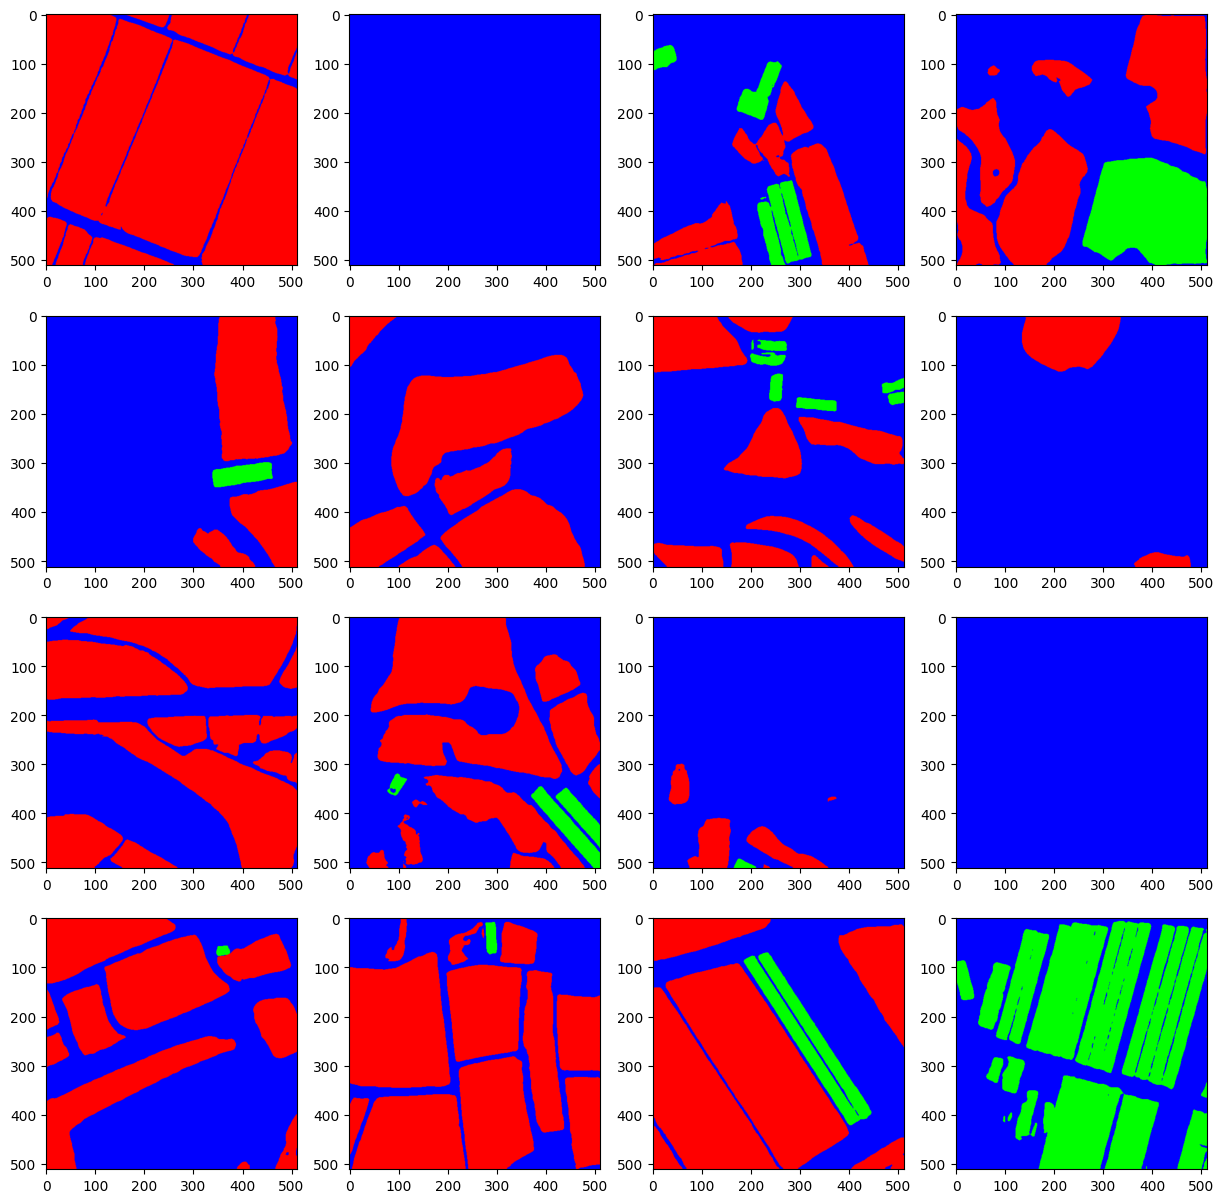

In [31]:
def post_processing(pred):
    pred = tf.one_hot(np.argmax(pred, -1), 3)
    return pred

x, y = next(gen)
pred = post_processing(model(x))

plt.figure(figsize=(15, 15))

for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i*4+j+1)
        plt.imshow(pred[i*4+j])

In [8]:
crops=pred[9][...,0] # Crops
vinyl=pred[0][...,1] # vinyl
image = crops
points = []

image_max = tf.reshape(image, -1)
image_max_idx = tf.argmax(image_max)
x = int(image_max_idx)//512
y = int(image_max_idx)%512

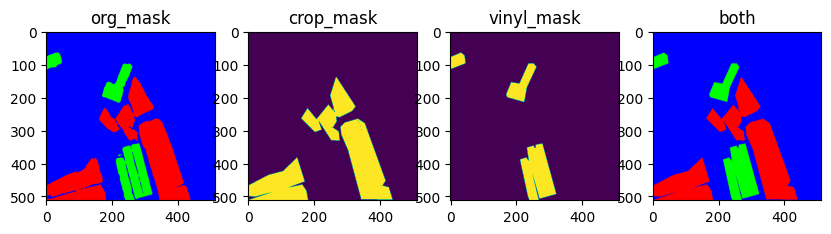

In [32]:
import sys
import cv2
from rdp import rdp
import matplotlib.pyplot as plt

sys.setrecursionlimit(1000000000)

class MaskToPolygon:
    
    # global area
    points = []
    dx = [0, 1, 1, 1, 0, -1, -1, -1]
    dy = [-1, -1, 0, 1, 1, 1, 0, -1]
    
    def __init__(self, epsilon:float = 5., threshold:int = 100):
        self.epsilon = epsilon
        self.threshold = threshold
        
    def __call__(self, image: np.ndarray, option:str="B"):
        image = image.astype(np.uint8) * 255
        
        if image.shape[0] != 512 or image.shape[1] != 512:
            raise Exception("Invalid Shape Error\n\n image.shape must (512, 512, 3) and must use 3 channel")
        
        if option == "B":
            crop_image = image[...,0]
            vinyl_image = image[...,1]
            crop_mask = self._call_option_single(crop_image)
            vinyl_mask = self._call_option_single(vinyl_image)
            remain_mask = np.clip(np.ones((512, 512))*255 - crop_mask - vinyl_mask, 0, 255)
            res_mask = np.concatenate((crop_mask[..., np.newaxis]
                                       , vinyl_mask[..., np.newaxis]
                                       , remain_mask[..., np.newaxis]), -1)
            return res_mask / 255.
        elif option == "C":
            image = image[...,0]
            return np.array(self._call_option_single(image))/255.
        elif option == "V":
            image = image[...,1]
            return np.array(self._call_option_single(image))/255.
        else:
            raise Exception("B(BOTH), C(CROP), V(VINYL) 중 올바른 option 값을 주십시오. \n 기본값은 C(CROP)입니다.")
        
    def _call_option_single(self, org_image):
        self.points = []
        contour_img = self.mask_to_contour(org_image)
        self.contour_img = np.array(contour_img)
        # self._visualize(org_image, self.contour_img)
        
        self._get_points()
        # cleared_contour  = self._points_to_contour(self.points)
        # cleared_mask     = self._points_to_mask(self.points)
        # self._visualize(cleared_mask, cleared_contour)
        
        rdp_points       = self._get_rdp_point()
        rdp_mask         = self._points_to_mask(rdp_points)
        # rdp_contour      = self.mask_to_contour(rdp_mask)
        # self._visualize(rdp_mask, rdp_contour)
        
        return rdp_mask
    
    def _get_rdp_point(self):
        rdp_points = []
        for section_points in self.points:
            section_points = np.array(section_points)
            simplified_points = rdp(section_points, epsilon=self.epsilon)
            rdp_points.append(list(simplified_points))
        # rdp_points = map(list, rdp_points)
        return rdp_points
    
    def _points_to_mask(self, points):
        mask = np.zeros_like(self.contour_img, dtype=np.uint8)
        for section_points in points:
            cv2.fillPoly(mask, np.expand_dims(section_points, 0), color=(255))
        return mask
    
    def _points_to_contour(self, points):
        contour_img = np.zeros_like(self.contour_img)
        if not points:
            return contour_img
        cv2.drawContours(contour_img, np.expand_dims(np.array(sum(points, [])), -2), -1, (255, 255, 255), 1)
        return contour_img
    
    def _dfs(self, x, y, segment):
        self.contour_img[y][x] = 0
        for i, j in zip(self.dx, self.dy):
            nx = x + i
            ny = y + j
            if 0 <= nx < 512 and 0 <= ny < 512 and self.contour_img[ny][nx]:
                self.points[segment].append([nx, ny])
                self._dfs(nx, ny, segment)
    
    def _get_points(self, segment=0):
        while np.sum(self.contour_img):
            image_max = tf.reshape(self.contour_img, -1)
            image_max_idx = tf.argmax(image_max)
            y = int(image_max_idx) // 512
            x = int(image_max_idx) % 512
            self.points.append([[x, y]])
            self._dfs(x, y, segment)
            if len(self.points[segment]) < self.threshold:
                self.points.pop()
                segment -= 1
            segment += 1
            
    
    def mask_to_contour(self, image):
        contours, _ = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        contour_img = np.zeros_like(image)
        cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 1)
        return contour_img
    
    def _visualize(self, img, contour_img = None):
        if contour_img is None:
            plt.imshow(img)
            plt.show()
        else:
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.subplot(1, 2, 2)
            plt.imshow(contour_img)


import time
start = time.time()
MTP = MaskToPolygon()
image = np.array(pred[2])


plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("org_mask")
plt.imshow(image)
plt.subplot(1, 4, 2)
plt.title("crop_mask")
plt.imshow(MTP(image, "C"))

plt.subplot(1, 4, 3)
plt.title("vinyl_mask")
plt.imshow(MTP(image, "V"))
plt.subplot(1, 4, 4)
plt.title("both")
plt.imshow(MTP(image, "B"))

0


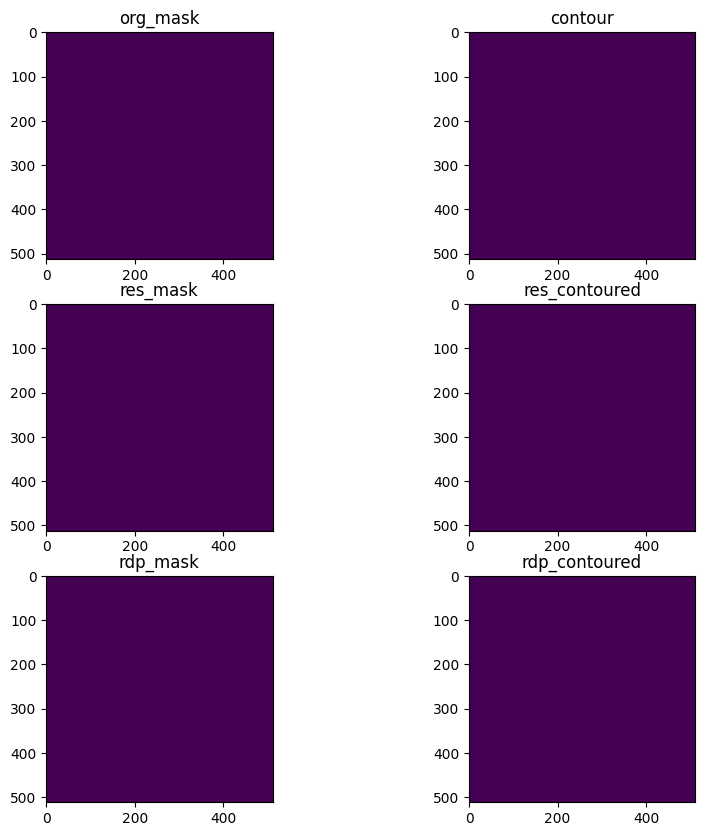

In [15]:
import sys
import cv2
from rdp import rdp
sys.setrecursionlimit(1000000000)

def dfs(x, y, segment):
    global points, contour_image
    contour_image[x][y] = 0
    for i, j in zip(dx, dy):
        nx = x + i
        ny = y + j
        if 0 <= nx < 512 and 0 <= ny < 512 and contour_image[nx, ny]:
            # print(nx, ny, image[nx, ny])
            points[segment].append([ny, nx])
            dfs(nx, ny, segment)

def mask_to_contour(image):
    image = (np.array(image) * 255).astype(np.uint8)
    contours, hier = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    contour_image = np.zeros_like(image)
    
    
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)
    return contour_image

def point_to_contour(points):
    global image
    contour_image = np.zeros_like(image)
    if not points:
        return contour_image
    cv2.drawContours(contour_image, np.expand_dims(np.array(sum(points, [])), -2), -1, (255, 255, 255), 1)
    return contour_image

def points_to_mask(points):
    global image
    mask = np.zeros_like(image, dtype=np.uint8)
    for section_points in points:
        # print(np.expand_dims(section_points, 0))
        # print(np.expand_dims(section_points, 1))
        cv2.fillPoly(mask, np.expand_dims(section_points, 0), color=(255))
    return mask

def get_rdp_point(points, epsilon=2):
    res_points = []
    for section_points in points:
        section_points = np.array(section_points)
        simplified_points = rdp(section_points, epsilon=epsilon)
        res_points.append(simplified_points)
    res_points = map(list, res_points)
    # plt.imshow((point_to_contour(res_points)))
    return res_points

def get_points(image, segment=0, thr=100):
    global points
    while np.sum(contour_image) != 0:
        image_max = tf.reshape(contour_image, -1)
        image_max_idx = tf.argmax(image_max)
        x = int(image_max_idx)//512
        y = int(image_max_idx)%512
        points.append([[y, x]])
        dfs(x, y, segment)
        if len(points[segment]) < thr:
            points.pop()
            segment -= 1
        segment += 1
    return points

crops=pred[12][...,0] # Crops
vinyl=pred[0][...,1] # vinyl
image = vinyl

target_image = image

contour_image = mask_to_contour(image)
points = []

dx = [0, 1, 1, 1, 0, -1, -1, -1]
dy = [-1, -1, 0, 1, 1, 1, 0, -1]

get_points(contour_image)
result_image = point_to_contour(points)
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.title("org_mask")
# image2 = cv2.erode(np.array(image), np.ones((13, 13)))
# image2 = cv2.dilate(np.array(image), np.ones((8, 8)))
# print(image2.shape)
plt.imshow(image)
plt.subplot(3, 2, 2)
plt.title("contour")
plt.imshow(mask_to_contour(image))

plt.subplot(3, 2, 3)
plt.title("res_mask")
plt.imshow(points_to_mask(points))
plt.subplot(3, 2, 4)
plt.title("res_contoured")
plt.imshow(result_image)

plt.subplot(3, 2, 5)
rdp_points = get_rdp_point(points, epsilon=5)
plt.title("rdp_mask")
rdp_mask = points_to_mask(rdp_points)
plt.imshow(rdp_mask)
plt.subplot(3, 2, 6)
plt.title("rdp_contoured")
plt.imshow(mask_to_contour(rdp_mask))

print(len(points))

In [152]:
def mask_to_contour(image):
    image = (np.array(image) * 255).astype(np.uint8)
    contours, hier = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    contour_image = np.zeros_like(image)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)
    return contour_image, contours

def get_rdp_point(points, epsilon=2):
    res_points = []
    for section_points in points:
        simplified_points = rdp(section_points, epsilon=epsilon)
        res_points.append([[p[0], p[1]] for p in simplified_points])
    return res_points

def points_to_mask(mask, points):
    # for section_points in points:
    cv2.fillPoly(mask, np.array([points],np.int32), color=(255))
    return mask

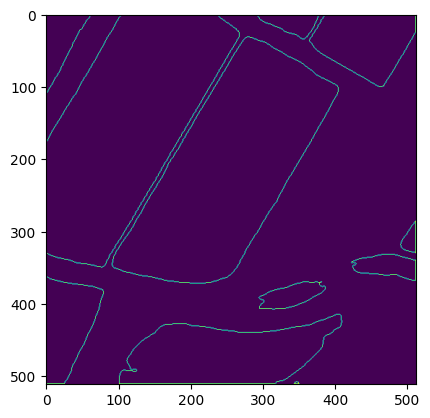

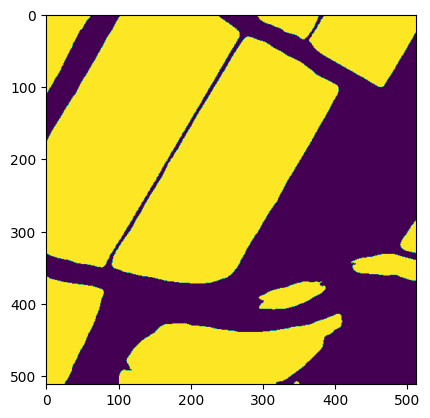

In [153]:
crops=pred[0][...,0] # Crops
vinyl=pred[0][...,1] # vinyl
target_image = pred[8][...,0]

image = target_image

ct, ctp = mask_to_contour(image)

plt.imshow(ct)
plt.show()

rdp_points = [get_rdp_point(points, epsilon=4) for points in ctp]
rdp_mask = np.zeros((512,512,1), dtype=np.uint8)
for points in rdp_points:
    rdp_mask = points_to_mask(rdp_mask, points)
plt.imshow(rdp_mask)

In [ ]:
from rdp import rdp
res_points = []
for section_points in points:
    section_points = np.array(section_points)
    simplified_points = rdp(section_points, epsilon=0.5)
    res_points.append(simplified_points)
res_points = map(list, res_points)
plt.imshow((point_to_contour(res_points)))

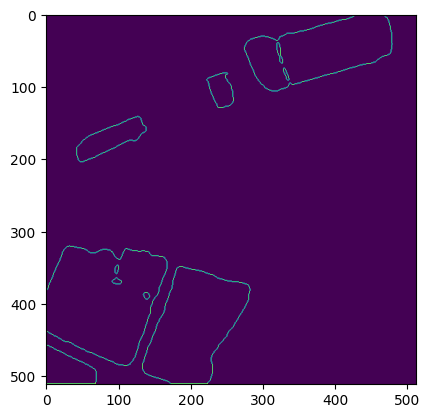

In [37]:
contour_image = mask_to_contour(image)
plt.imshow(contour_image)

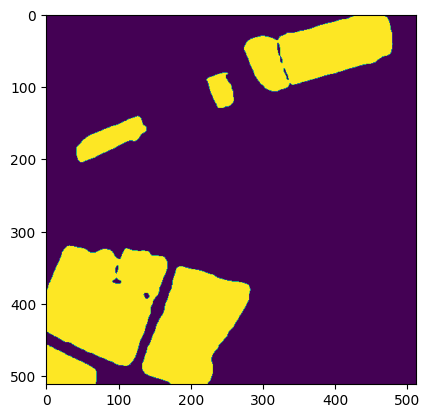

In [38]:
plt.imshow(image)

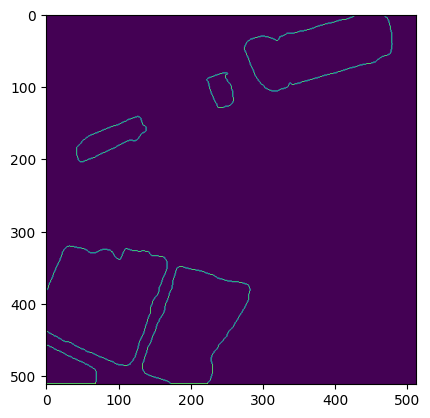

In [39]:
contour_image = np.zeros_like(image)
cv2.drawContours(contour_image, np.expand_dims(np.array(sum(points, [])), -2), -1, (255, 255, 255), 1)
plt.imshow(contour_image)

[(0, 431),
 (0, 432),
 (0, 433),
 (0, 434),
 (0, 435),
 (0, 436),
 (0, 437),
 (0, 438),
 (0, 439),
 (0, 440),
 (0, 441),
 (0, 442),
 (0, 443),
 (0, 444),
 (0, 445),
 (0, 446),
 (0, 447),
 (0, 448),
 (0, 449),
 (0, 450),
 (0, 451),
 (0, 452),
 (0, 453),
 (0, 454),
 (0, 455),
 (0, 456),
 (0, 457),
 (0, 458),
 (0, 459),
 (0, 460),
 (0, 461),
 (0, 462),
 (0, 463),
 (0, 464),
 (0, 465),
 (0, 466),
 (0, 467),
 (1, 468),
 (2, 468),
 (3, 469),
 (4, 470),
 (4, 471),
 (5, 472),
 (6, 472),
 (7, 473),
 (8, 473),
 (9, 474),
 (10, 474),
 (11, 474),
 (12, 475),
 (13, 475),
 (14, 475),
 (15, 475),
 (16, 476),
 (17, 476),
 (18, 476),
 (19, 476),
 (20, 476),
 (21, 476),
 (22, 477),
 (23, 477),
 (24, 477),
 (25, 478),
 (26, 478),
 (27, 478),
 (28, 478),
 (29, 478),
 (30, 478),
 (31, 478),
 (32, 478),
 (33, 478),
 (34, 478),
 (35, 478),
 (36, 478),
 (37, 478),
 (38, 478),
 (39, 478),
 (40, 478),
 (41, 479),
 (42, 478),
 (43, 478),
 (44, 478),
 (45, 478),
 (46, 478),
 (47, 478),
 (48, 478),
 (49, 477),
 (5